In [75]:
import pandas as pd
import pickle
import os
import numpy as np


from config import BASE_DIR
print(os.getcwd()+' -> ',end=' ')
os.chdir(BASE_DIR)
print(BASE_DIR)

from scripts.indicators import find_pivots,donchian

C:\Users\lbisa\Dropbox\Cripto\python\InvestingEvolution\ie\www ->  C:\Users\lbisa\Dropbox\Cripto\python\InvestingEvolution\ie\www


BNBUSDT    1.430209
ADAUSDT    1.547063
DOTUSDT    1.653493
BTCUSDT    1.000000
XRPUSDT    1.725560
ETHUSDT    1.318775
TRXUSDT    1.318829
Name: mean, dtype: float64


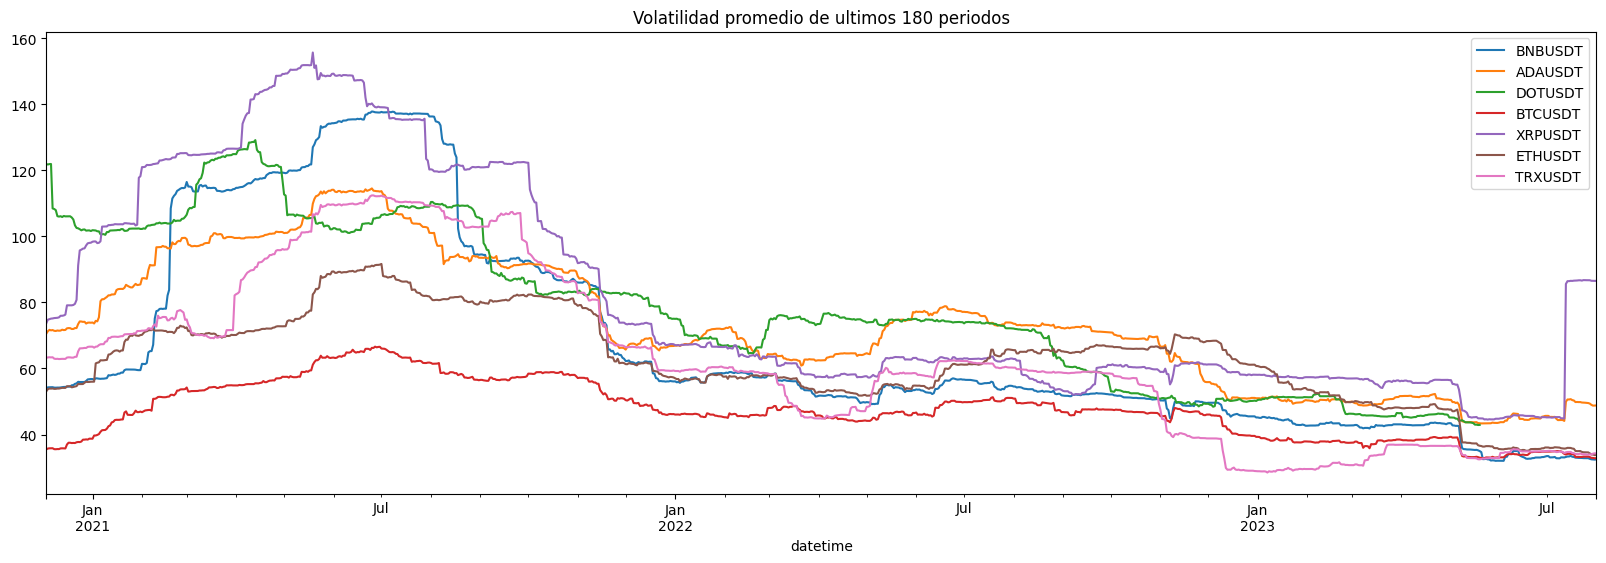

In [81]:
symbols = { 'BTCUSDT',
            'ETHUSDT',
            'BNBUSDT',
            'TRXUSDT',
            'ADAUSDT',
            'DOTUSDT',
            'XRPUSDT',
}

periodos = 180

start = False
for symbol in symbols:
    klines_file = f'./backtest/klines/2d01/Completo_{symbol}_2d01_2021-01-01_2023-07-31.DataFrame'
    with open(klines_file, 'rb') as file:
        tmp_df = pickle.load(file)
        qty_velas = tmp_df['datetime'].count()
        tmp_df[symbol] = tmp_df['close'].pct_change().rolling(periodos).std() * np.sqrt(periodos)*100
        
        if not start:
            df = tmp_df[['datetime',symbol]].copy()
            start = True
        else:
            df[symbol] = tmp_df[symbol].copy()
df.set_index('datetime',inplace=True)

title = f'Volatilidad promedio de ultimos {periodos} periodos'
df[periodos:].plot(figsize=(20,6),title=title)
#print(df[periodos:].describe())
df_std = df[periodos:].describe().loc['mean']

btc_base = df_std['BTCUSDT']
df_std = df_std/btc_base
print('Factor a aplicar a cada par')
print(df_std)
